# Notes Analytics Dashboard

Este notebook analiza los datos de notas almacenadas en DynamoDB para generar insights sobre:
- **Histograma** de cantidad de notas por día
- **Gráfico circular** con la proporción de sentimientos publicados

## Import Required Libraries

Importamos las librerías necesarias para análisis de datos, visualización y conexión a AWS DynamoDB.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import boto3
from boto3.dynamodb.conditions import Key, Attr

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

✅ Libraries imported successfully!


## Database Connection Setup

Configuramos la conexión a AWS DynamoDB. Necesitaremos obtener el nombre de la tabla desde el stack desplegado.

In [ ]:
AWS_REGION = 'us-east-1'

dynamodb = boto3.resource('dynamodb', region_name=AWS_REGION)
cloudformation = boto3.client('cloudformation', region_name=AWS_REGION)

try:
    response = cloudformation.describe_stacks(StackName='BackendStack')
    outputs = response['Stacks'][0]['Outputs']
    
    table_name = None
    for output in outputs:
        if output['OutputKey'] == 'DynamoDBTableName':
            table_name = output['OutputValue']
            break
    
    if table_name:
        print(f"Found DynamoDB table: {table_name}")
        notes_table = dynamodb.Table(table_name)
    else:
        print("Table name not found in stack outputs")
        table_name = "Notes"
        notes_table = dynamodb.Table(table_name)
        print(f"Using fallback table name: {table_name}")
        
except Exception as e:
    print(f"Error connecting to DynamoDB: {e}")
    print("Make sure you have AWS credentials configured and the backend is deployed")

✅ Found DynamoDB table: Notes


## Data Extraction and Preparation

Extraemos todos los datos de notas de DynamoDB y los preparamos para análisis.

In [ ]:
def extract_notes_data():
    try:
        response = notes_table.scan()
        items = response['Items']
        
        while 'LastEvaluatedKey' in response:
            response = notes_table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
            items.extend(response['Items'])
        
        print(f"Extracted {len(items)} notes from DynamoDB")
        return items
        
    except Exception as e:
        print(f"Error extracting data: {e}")
        return []

def prepare_dataframe(items):
    if not items:
        return pd.DataFrame()
    
    df = pd.DataFrame(items)
    df['dateCreated'] = pd.to_datetime(df['dateCreated'])
    df['date'] = df['dateCreated'].dt.date
    df['sentiment'] = df['sentiment'].str.upper()
    
    print(f"DataFrame prepared with {len(df)} notes")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Sentiments found: {df['sentiment'].unique()}")
    
    return df

notes_data = extract_notes_data()
df_notes = prepare_dataframe(notes_data)

if not df_notes.empty:
    print("\nDataset Overview:")
    print(df_notes.head())
    print("\nDataset Info:")
    print(df_notes.info())

✅ Extracted 51 notes from DynamoDB
✅ DataFrame prepared with 51 notes
📅 Date range: 2025-08-03 to 2025-08-17
💭 Sentiments found: ['NEUTRAL' 'HAPPY' 'SAD' 'ANGRY']

📊 Dataset Overview:
                                                text  \
0  Carbo statim ceno. Amiculum vitium subnecto am...   
1  Ratione magni sequi valeo voluptatum trepide c...   
2                 Angulus aperio desino cursim vero.   
3  Concido atavus voro thymbra unus beatae sonitu...   
4  Causa deorsum auctus blandior cubo adflicto ve...   

                       dateCreated                          id sentiment  \
0 2025-08-09 17:20:59.530000+00:00  01K2WTYY8EZ5P95G00SPW7Y242   NEUTRAL   
1 2025-08-07 11:46:22.645000+00:00  01K2WTYY8E77487MAS8Q9JX1X7     HAPPY   
2 2025-08-04 01:09:54.076000+00:00  01K2WTYY8EZMCA8MKFENTDQBZT     HAPPY   
3 2025-08-10 20:24:53.986000+00:00  01K2WTYY8C6R2V30RNDGZ25VRE   NEUTRAL   
4 2025-08-13 21:00:50.055000+00:00  01K2WTYY8E43SY3R3RK4D18TP8       SAD   

         date  
0  202

## Daily Notes Histogram

Creamos un histograma que muestra la distribución de notas creadas por día.

/var/folders/hb/jtf_72jj6v71ps43wxd_350m0000gn/T/ipykernel_51155/2646146513.py:38: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hb/jtf_72jj6v71ps43wxd_350m0000gn/T/ipykernel_51155/2646146513.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/santiagozamora/Code/coding_challenge/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santiagozamora/Code/coding_challenge/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


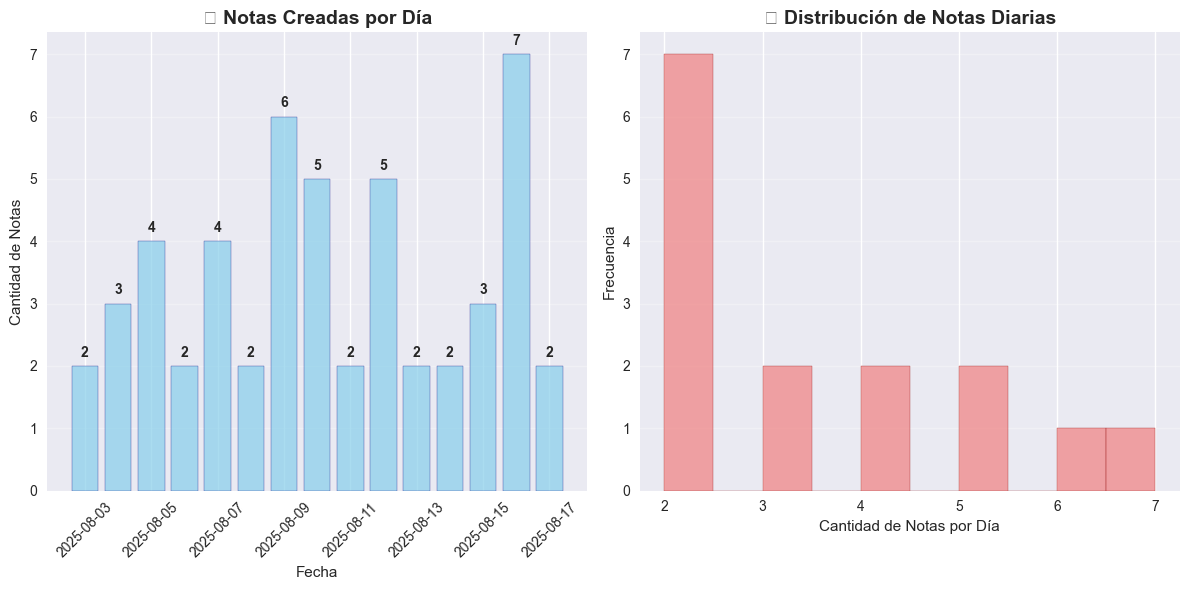


📈 Estadísticas de Notas Diarias:
• Total de días con notas: 15
• Promedio de notas por día: 3.40
• Máximo de notas en un día: 7
• Mínimo de notas en un día: 2


In [ ]:
def create_daily_notes_histogram(df):
    if df.empty:
        print("No data available for histogram")
        return
    
    daily_counts = df.groupby('date').size().reset_index(name='notes_count')
    daily_counts['date'] = pd.to_datetime(daily_counts['date'])
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(daily_counts['date'], daily_counts['notes_count'], 
            color='skyblue', alpha=0.7, edgecolor='navy')
    plt.title('Notas Creadas por Día', fontsize=14, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de Notas')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(daily_counts['notes_count']):
        plt.text(daily_counts['date'].iloc[i], v + 0.1, str(v), 
                ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(1, 2, 2)
    plt.hist(daily_counts['notes_count'], bins=10, 
             color='lightcoral', alpha=0.7, edgecolor='darkred')
    plt.title('Distribución de Notas Diarias', fontsize=14, fontweight='bold')
    plt.xlabel('Cantidad de Notas por Día')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nEstadísticas de Notas Diarias:")
    print(f"• Total de días con notas: {len(daily_counts)}")
    print(f"• Promedio de notas por día: {daily_counts['notes_count'].mean():.2f}")
    print(f"• Máximo de notas en un día: {daily_counts['notes_count'].max()}")
    print(f"• Mínimo de notas en un día: {daily_counts['notes_count'].min()}")

create_daily_notes_histogram(df_notes)

## Sentiment Proportion Pie Chart

Generamos un gráfico circular que muestra la proporción de diferentes sentimientos en las notas publicadas.

/var/folders/hb/jtf_72jj6v71ps43wxd_350m0000gn/T/ipykernel_51155/143802736.py:58: UserWarning: Glyph 128173 (\N{THOUGHT BALLOON}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hb/jtf_72jj6v71ps43wxd_350m0000gn/T/ipykernel_51155/143802736.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/santiagozamora/Code/coding_challenge/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128173 (\N{THOUGHT BALLOON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/santiagozamora/Code/coding_challenge/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


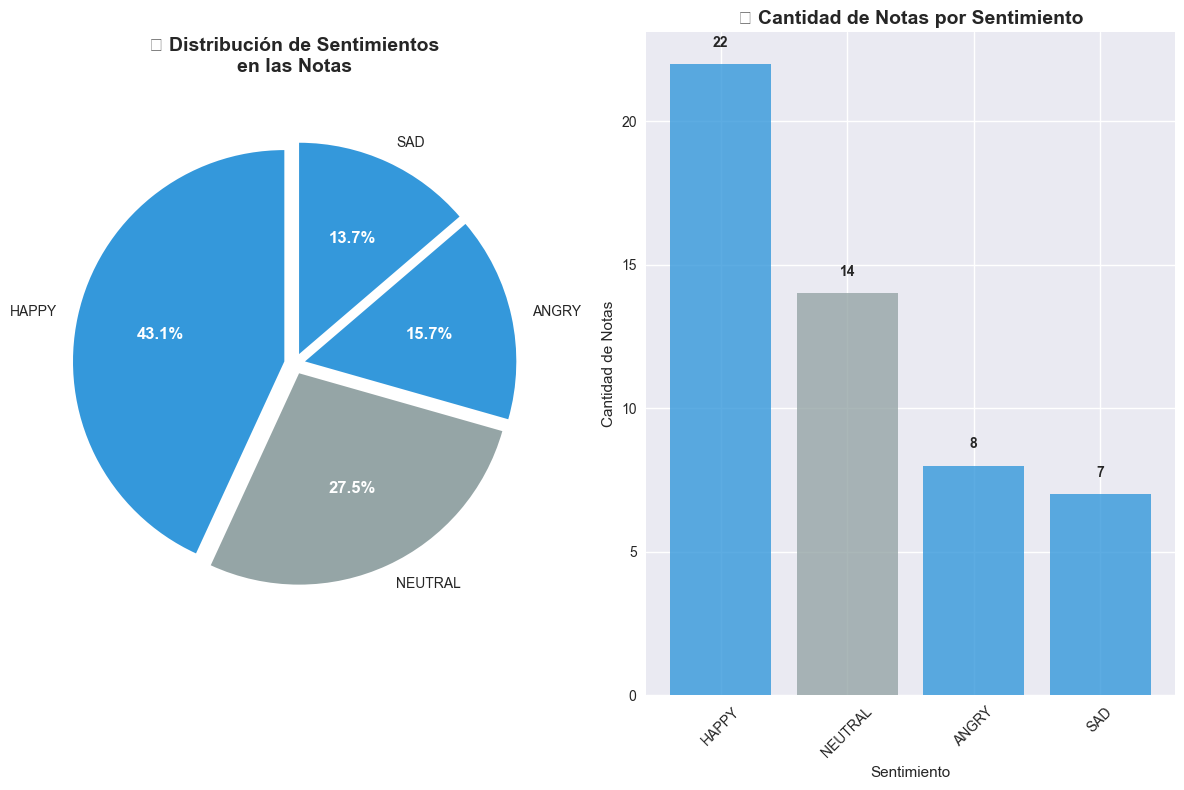


💭 Estadísticas de Sentimientos:
• HAPPY: 22 notas (43.1%)
• NEUTRAL: 14 notas (27.5%)
• ANGRY: 8 notas (15.7%)
• SAD: 7 notas (13.7%)

📝 Total de notas analizadas: 51


In [ ]:
def create_sentiment_pie_chart(df):
    if df.empty:
        print("No data available for pie chart")
        return
    
    sentiment_counts = df['sentiment'].value_counts()
    
    colors = {
        'POSITIVE': '#2ecc71',
        'NEGATIVE': '#e74c3c',
        'NEUTRAL': '#95a5a6',
        'MIXED': '#f39c12'
    }
    
    pie_colors = [colors.get(sentiment, '#3498db') for sentiment in sentiment_counts.index]
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(1, 2, 1)
    wedges, texts, autotexts = plt.pie(sentiment_counts.values, 
                                       labels=sentiment_counts.index,
                                       colors=pie_colors,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       explode=[0.05] * len(sentiment_counts))
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    plt.title('Distribución de Sentimientos\nen las Notas', 
              fontsize=14, fontweight='bold', pad=20)
    
    plt.subplot(1, 2, 2)
    bars = plt.bar(sentiment_counts.index, sentiment_counts.values, 
                   color=pie_colors, alpha=0.8)
    
    plt.title('Cantidad de Notas por Sentimiento', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Sentimiento')
    plt.ylabel('Cantidad de Notas')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, sentiment_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(value), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nEstadísticas de Sentimientos:")
    total_notes = sentiment_counts.sum()
    for sentiment, count in sentiment_counts.items():
        percentage = (count / total_notes) * 100
        print(f"• {sentiment}: {count} notas ({percentage:.1f}%)")
    
    print(f"\nTotal de notas analizadas: {total_notes}")

create_sentiment_pie_chart(df_notes)